In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys

In [20]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from src.core.pendulum import PendulumSystem
from src.core.spore import Spore

In [21]:
from src.core.pendulum import PendulumSystem
from src.core.spore import Spore

In [22]:
pendulum = PendulumSystem()
spore = Spore(dt=0.01, 
              position=(0, 2),
              pendulum=pendulum, 
              goal_position=(np.pi, 0))

A_cont, B_cont = pendulum.linearize_continuous((0, 0))

print('A')
print(A_cont)
print()
print('B')
print(B_cont)
print()
print('cost', spore.cost)

A
[[ 0.     1.   ]
 [-4.905 -0.1  ]]

B
[[0.]
 [1.]]

cost 13.869604401089358


In [23]:
dt = 0.01

A = 1 + A_cont * dt
B = B_cont * dt

controls = spore.sample_mesh_controls(10)
next_states = spore.simulate_controls(controls)

print('A')
print(A)
print()
print('B')
print(B)
print()
print('cost', spore.cost)

print('controls')
print(controls)
print()

print('next_states')
print(next_states)
print()

costs = []

for state in next_states:
    costs.append(spore.cost_function(state))

costs = np.array(costs)
print('costs')
print(costs)
print()


A
[[1.      1.01   ]
 [0.95095 0.999  ]]

B
[[0.  ]
 [0.01]]

cost 13.869604401089358
controls
[-1.         -0.77777778 -0.55555556 -0.33333333 -0.11111111  0.11111111
  0.33333333  0.55555556  0.77777778  1.        ]

next_states
[[0.19241741 1.83288418]
 [0.19352031 1.85481534]
 [0.19462321 1.87674651]
 [0.19572611 1.89867767]
 [0.19682901 1.92060883]
 [0.19793191 1.94253999]
 [0.19903481 1.96447116]
 [0.20013771 1.98640232]
 [0.20124061 2.00833348]
 [0.20234351 2.03026464]]

costs
[12.05709905 12.13147051 12.20680635 12.28310658 12.36037119 12.43860019
 12.51779357 12.59795134 12.67907349 12.76116003]



In [24]:
def compute_next_cost(params, spore, pendulum):
    """
    Вычисляет стоимость следующего состояния по управлению и временному шагу
    
    Args:
        params: [u, dt] - управление и временной шаг
        spore: объект споры
        pendulum: объект маятника
    
    Returns:
        float: стоимость следующего состояния
    """
    u, dt = params
    
    # Получаем текущую позицию
    cur_pos = spore.calc_2d_pos()
    
    # Линеаризация в текущей точке
    A_cont, B_cont = pendulum.linearize_continuous(cur_pos)
    
    # Дискретизация
    A_d = np.eye(2) + A_cont * dt
    B_d = B_cont * dt
    
    # Вычисляем следующее состояние
    next_pos = A_d @ cur_pos + B_d @ np.array([u])
    
    # Возвращаем стоимость следующего состояния
    return spore.cost_function(next_pos)

In [27]:
from scipy.optimize import minimize
import time

bounds = [(-1, 1), (0.001, 0.1)]

results = {}
print("=== Градиентная оптимизация (L-BFGS-B) ===")
start_time = time.time()

# Начальное приближение
x0 = [0.0, 0.01]  # u=0, dt=0.01

# Оптимизация методом L-BFGS-B
result_gradient = minimize(
    fun=compute_next_cost, 
    x0=x0, 
    args=(spore, pendulum),
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True}
)

finish_time = time.time()
print(f"Время выполнения: {finish_time - start_time:.3f} сек")

print(result_gradient)

=== Градиентная оптимизация (L-BFGS-B) ===
Время выполнения: 0.002 сек
  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 12.18736733965344
        x: [-1.000e+00  1.000e-01]
      nit: 2
      jac: [ 3.760e-01 -1.628e+01]
     nfev: 18
     njev: 6
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [31]:
from scipy.optimize import minimize, differential_evolution
import time

def compute_next_cost(params, spore, pendulum):
    """
    Вычисляет стоимость следующего состояния по управлению и временному шагу
    
    Args:
        params: [u, dt] - управление и временной шаг
        spore: объект споры
        pendulum: объект маятника
    
    Returns:
        float: стоимость следующего состояния
    """
    u, dt = params
    
    # Получаем текущую позицию
    cur_pos = spore.calc_2d_pos()
    
    # Линеаризация в текущей точке
    A_cont, B_cont = pendulum.linearize_continuous(cur_pos)
    
    # Дискретизация
    A_d = np.eye(2) + A_cont * dt
    B_d = B_cont * dt
    
    # Вычисляем следующее состояние
    next_pos = A_d @ cur_pos + B_d @ np.array([u])
    
    # Возвращаем стоимость следующего состояния
    return spore.cost_function(next_pos)

def optimize_control_and_dt(spore, pendulum, method='both'):
    """
    Оптимизирует управление u и временной шаг dt
    
    Args:
        spore: объект споры
        pendulum: объект маятника
        method: 'gradient', 'global', 'both'
    
    Returns:
        dict: результаты оптимизации
    """
    # Границы: u в [-1, 1], dt в [0.001, 0.1]
    bounds = [(-1, 1), (0.001, 0.1)]
    
    results = {}
    
    if method in ['gradient', 'both']:
        print("=== Градиентная оптимизация (L-BFGS-B) ===")
        start_time = time.time()
        
        # Начальное приближение
        x0 = [0.0, 0.01]  # u=0, dt=0.01
        
        # Оптимизация методом L-BFGS-B
        result_gradient = minimize(
            fun=compute_next_cost, 
            x0=x0, 
            args=(spore, pendulum),
            method='L-BFGS-B',
            bounds=bounds,
            options={'disp': True}
        )
        
        gradient_time = time.time() - start_time
        results['gradient'] = {
            'result': result_gradient,
            'time': gradient_time,
            'u_opt': result_gradient.x[0],
            'dt_opt': result_gradient.x[1],
            'cost_opt': result_gradient.fun
        }
        
        print(f"Оптимальное u: {result_gradient.x[0]:.4f}")
        print(f"Оптимальное dt: {result_gradient.x[1]:.4f}")
        print(f"Минимальная стоимость: {result_gradient.fun:.4f}")
        print(f"Время выполнения: {gradient_time:.3f} сек")
        print(f"Сходимость: {result_gradient.success}")
        print()
    
    if method in ['global', 'both']:
        print("=== Глобальная оптимизация (Differential Evolution) ===")
        start_time = time.time()
        
        # Differential Evolution - глобальный оптимизатор
        result_global = differential_evolution(
            compute_next_cost,
            bounds,
            args=(spore, pendulum),
            maxiter=100,
            popsize=15,
            disp=True,
            seed=42
        )
        
        global_time = time.time() - start_time
        results['global'] = {
            'result': result_global,
            'time': global_time,
            'u_opt': result_global.x[0],
            'dt_opt': result_global.x[1],
            'cost_opt': result_global.fun
        }
        
        print(f"Оптимальное u: {result_global.x[0]:.4f}")
        print(f"Оптимальное dt: {result_global.x[1]:.4f}")
        print(f"Минимальная стоимость: {result_global.fun:.4f}")
        print(f"Время выполнения: {global_time:.3f} сек")
        print(f"Сходимость: {result_global.success}")
        print()
    
    return results

# Тестируем оптимизацию
print("Текущая стоимость:", spore.cost)
print("Текущая позиция:", spore.calc_2d_pos())
print("Целевая позиция:", spore.logic.goal_position_2d)
print()


Текущая стоимость: 13.869604401089358
Текущая позиция: [0. 2.]
Целевая позиция: [3.14159265 0.        ]



In [32]:
# Запускаем оптимизацию
results = optimize_control_and_dt(spore, pendulum, method='both')

# Сравниваем результаты
if 'gradient' in results and 'global' in results:
    print("=== СРАВНЕНИЕ МЕТОДОВ ===")
    grad_res = results['gradient']
    glob_res = results['global']
    
    print(f"Градиентный метод: u={grad_res['u_opt']:.4f}, dt={grad_res['dt_opt']:.4f}, cost={grad_res['cost_opt']:.4f}, время={grad_res['time']:.3f}с")
    print(f"Глобальный метод:  u={glob_res['u_opt']:.4f}, dt={glob_res['dt_opt']:.4f}, cost={glob_res['cost_opt']:.4f}, время={glob_res['time']:.3f}с")
    
    # Определяем лучший результат
    if grad_res['cost_opt'] < glob_res['cost_opt']:
        print("🏆 Градиентный метод показал лучший результат!")
        best_result = grad_res
    else:
        print("🏆 Глобальный метод показал лучший результат!")
        best_result = glob_res
    
    print(f"\nЛучший результат: u={best_result['u_opt']:.4f}, dt={best_result['dt_opt']:.4f}")
    print(f"Уменьшение стоимости: {spore.cost - best_result['cost_opt']:.4f}")


=== Градиентная оптимизация (L-BFGS-B) ===
Оптимальное u: -1.0000
Оптимальное dt: 0.1000
Минимальная стоимость: 12.1874
Время выполнения: 0.002 сек
Сходимость: True

=== Глобальная оптимизация (Differential Evolution) ===
differential_evolution step 1: f(x)= 12.356221714605107
differential_evolution step 2: f(x)= 12.354240913853825
differential_evolution step 3: f(x)= 12.354240913853825
differential_evolution step 4: f(x)= 12.233621361889456
differential_evolution step 5: f(x)= 12.233621361889456
differential_evolution step 6: f(x)= 12.233621361889456
differential_evolution step 7: f(x)= 12.215324705185816
Polishing solution with 'L-BFGS-B'
Оптимальное u: -1.0000
Оптимальное dt: 0.1000
Минимальная стоимость: 12.1874
Время выполнения: 0.020 сек
Сходимость: True

=== СРАВНЕНИЕ МЕТОДОВ ===
Градиентный метод: u=-1.0000, dt=0.1000, cost=12.1874, время=0.002с
Глобальный метод:  u=-1.0000, dt=0.1000, cost=12.1874, время=0.020с
🏆 Глобальный метод показал лучший результат!

Лучший результат: u=

Строим ландшафт функции стоимости...


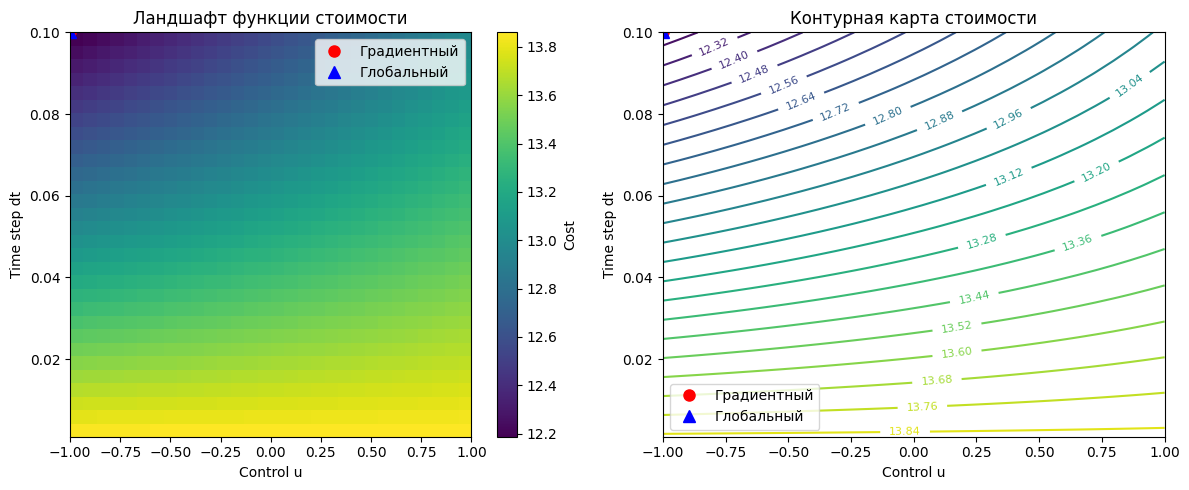

In [33]:
# Визуализация ландшафта функции стоимости
def plot_cost_landscape(spore, pendulum, u_range=(-1, 1), dt_range=(0.001, 0.1), resolution=50):
    """Строит тепловую карту функции стоимости"""
    u_vals = np.linspace(u_range[0], u_range[1], resolution)
    dt_vals = np.linspace(dt_range[0], dt_range[1], resolution)
    
    U, DT = np.meshgrid(u_vals, dt_vals)
    costs = np.zeros_like(U)
    
    for i in range(resolution):
        for j in range(resolution):
            costs[i, j] = compute_next_cost([U[i, j], DT[i, j]], spore, pendulum)
    
    plt.figure(figsize=(12, 5))
    
    # Тепловая карта
    plt.subplot(1, 2, 1)
    im = plt.imshow(costs, extent=[u_range[0], u_range[1], dt_range[0], dt_range[1]], 
                    aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(im, label='Cost')
    plt.xlabel('Control u')
    plt.ylabel('Time step dt')
    plt.title('Ландшафт функции стоимости')
    
    # Отмечаем оптимальные точки если есть результаты
    if 'results' in globals():
        if 'gradient' in results:
            plt.plot(results['gradient']['u_opt'], results['gradient']['dt_opt'], 
                    'ro', markersize=8, label='Градиентный')
        if 'global' in results:
            plt.plot(results['global']['u_opt'], results['global']['dt_opt'], 
                    'b^', markersize=8, label='Глобальный')
        plt.legend()
    
    # Контурный график
    plt.subplot(1, 2, 2)
    contour = plt.contour(U, DT, costs, levels=20)
    plt.clabel(contour, inline=True, fontsize=8)
    plt.xlabel('Control u')
    plt.ylabel('Time step dt')
    plt.title('Контурная карта стоимости')
    
    # Отмечаем оптимальные точки
    if 'results' in globals():
        if 'gradient' in results:
            plt.plot(results['gradient']['u_opt'], results['gradient']['dt_opt'], 
                    'ro', markersize=8, label='Градиентный')
        if 'global' in results:
            plt.plot(results['global']['u_opt'], results['global']['dt_opt'], 
                    'b^', markersize=8, label='Глобальный')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return costs, U, DT

# Строим ландшафт (это может занять немного времени)
print("Строим ландшафт функции стоимости...")
costs, U, DT = plot_cost_landscape(spore, pendulum, resolution=30)


In [24]:
# Дополнительные эксперименты и проверка результатов

def test_optimization_result(spore, pendulum, u_opt, dt_opt):
    """Проверяем, действительно ли найденное решение хорошее"""
    print(f"=== ПРОВЕРКА РЕЗУЛЬТАТА: u={u_opt:.4f}, dt={dt_opt:.4f} ===")
    
    # Текущее состояние
    cur_pos = spore.calc_2d_pos()
    cur_cost = spore.cost_function(cur_pos)
    
    # Следующее состояние с оптимальными параметрами
    A_cont, B_cont = pendulum.linearize_continuous(cur_pos)
    A_d = np.eye(2) + A_cont * dt_opt
    B_d = B_cont * dt_opt
    next_pos = A_d @ cur_pos + B_d @ np.array([u_opt])
    next_cost = spore.cost_function(next_pos)
    
    print(f"Текущая позиция: [{cur_pos[0]:.3f}, {cur_pos[1]:.3f}]")
    print(f"Следующая позиция: [{next_pos[0]:.3f}, {next_pos[1]:.3f}]")
    print(f"Целевая позиция: [{spore.logic.goal_position_2d[0]:.3f}, {spore.logic.goal_position_2d[1]:.3f}]")
    print()
    print(f"Текущая стоимость: {cur_cost:.4f}")
    print(f"Следующая стоимость: {next_cost:.4f}")
    print(f"Улучшение: {cur_cost - next_cost:.4f}")
    print(f"Процент улучшения: {((cur_cost - next_cost) / cur_cost * 100):.2f}%")
    print()
    
    # Сравнение с некоторыми базовыми стратегиями
    print("=== Сравнение с базовыми стратегиями ===")
    
    strategies = [
        ("Нулевое управление", 0.0, 0.01),
        ("Максимальное управление", 1.0, 0.01),
        ("Минимальное управление", -1.0, 0.01),
        ("Большой шаг времени", 0.0, 0.1),
        ("Малый шаг времени", 0.0, 0.001),
    ]
    
    for name, u, dt in strategies:
        cost = compute_next_cost([u, dt], spore, pendulum)
        print(f"{name:25s}: u={u:5.1f}, dt={dt:5.3f} → cost={cost:.4f}")
    
    print(f"{'Оптимальное решение':25s}: u={u_opt:5.1f}, dt={dt_opt:5.3f} → cost={next_cost:.4f}")
    print()

# Проверяем лучший результат
if 'results' in globals() and results:
    if 'gradient' in results and 'global' in results:
        # Берем лучший результат
        if results['gradient']['cost_opt'] < results['global']['cost_opt']:
            best = results['gradient']
            method_name = "градиентный"
        else:
            best = results['global'] 
            method_name = "глобальный"
        
        print(f"Лучший результат найден {method_name} методом")
        test_optimization_result(spore, pendulum, best['u_opt'], best['dt_opt'])
    else:
        # Если есть только один результат
        key = list(results.keys())[0]
        test_optimization_result(spore, pendulum, results[key]['u_opt'], results[key]['dt_opt'])
else:
    print("Сначала запустите оптимизацию!")


Лучший результат найден глобальный методом
=== ПРОВЕРКА РЕЗУЛЬТАТА: u=-0.1844, dt=0.0010 ===
Текущая позиция: [2.000, 0.000]
Следующая позиция: [2.000, 0.004]
Целевая позиция: [3.142, 0.000]

Текущая стоимость: 1.3032
Следующая стоимость: 1.3032
Улучшение: -0.0000
Процент улучшения: -0.00%

=== Сравнение с базовыми стратегиями ===
Нулевое управление       : u=  0.0, dt=0.010 → cost=1.3049
Максимальное управление  : u=  1.0, dt=0.010 → cost=1.3058
Минимальное управление   : u= -1.0, dt=0.010 → cost=1.3042
Большой шаг времени      : u=  0.0, dt=0.100 → cost=1.4699
Малый шаг времени        : u=  0.0, dt=0.001 → cost=1.3033
Оптимальное решение      : u= -0.2, dt=0.001 → cost=1.3032



=== АНАЛИЗ ПОВЕДЕНИЯ ПО dt (при u=-0.184) ===
Текущая позиция: [2.000, 0.000]
Целевая позиция: [3.142, 0.000]

Минимальная стоимость: 1.303249 при dt=0.0010


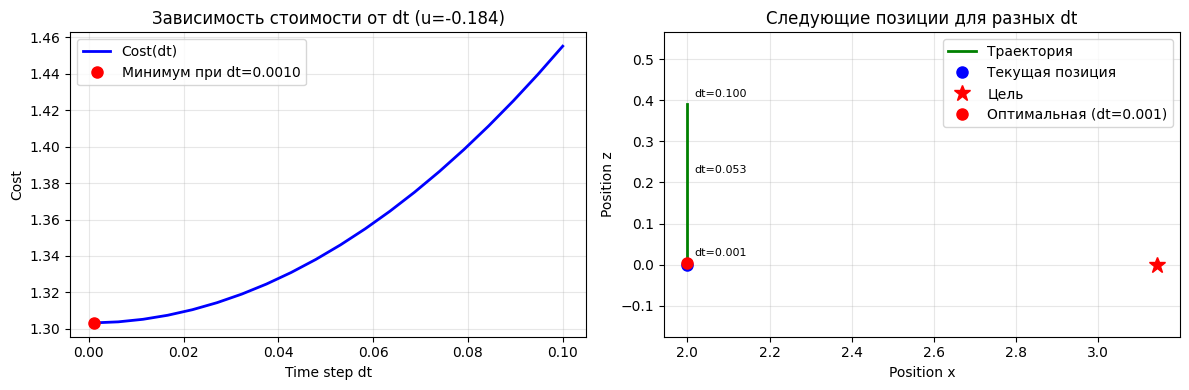

In [25]:
# Анализ: Почему оптимизаторы выбирают dt=0.001?

def analyze_dt_behavior(spore, pendulum, u_fixed=-0.1844):
    """Анализируем как стоимость зависит от dt при фиксированном u"""
    print(f"=== АНАЛИЗ ПОВЕДЕНИЯ ПО dt (при u={u_fixed:.3f}) ===")
    
    dt_values = np.linspace(0.001, 0.1, 20)
    costs = []
    
    cur_pos = spore.calc_2d_pos()
    print(f"Текущая позиция: [{cur_pos[0]:.3f}, {cur_pos[1]:.3f}]")
    print(f"Целевая позиция: [{spore.logic.goal_position_2d[0]:.3f}, {spore.logic.goal_position_2d[1]:.3f}]")
    print()
    
    for dt in dt_values:
        cost = compute_next_cost([u_fixed, dt], spore, pendulum)
        costs.append(cost)
    
    costs = np.array(costs)
    
    # Найдем минимум
    min_idx = np.argmin(costs)
    print(f"Минимальная стоимость: {costs[min_idx]:.6f} при dt={dt_values[min_idx]:.4f}")
    
    # Построим график
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(dt_values, costs, 'b-', linewidth=2, label='Cost(dt)')
    plt.plot(dt_values[min_idx], costs[min_idx], 'ro', markersize=8, label=f'Минимум при dt={dt_values[min_idx]:.4f}')
    plt.xlabel('Time step dt')
    plt.ylabel('Cost')
    plt.title(f'Зависимость стоимости от dt (u={u_fixed:.3f})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Поведение следующих позиций
    plt.subplot(1, 2, 2)
    next_positions = []
    
    for dt in dt_values:
        A_cont, B_cont = pendulum.linearize_continuous(cur_pos)
        A_d = np.eye(2) + A_cont * dt
        B_d = B_cont * dt
        next_pos = A_d @ cur_pos + B_d @ np.array([u_fixed])
        next_positions.append(next_pos)
    
    next_positions = np.array(next_positions)
    
    plt.plot(next_positions[:, 0], next_positions[:, 1], 'g-', linewidth=2, label='Траектория')
    plt.plot(cur_pos[0], cur_pos[1], 'bo', markersize=8, label='Текущая позиция')
    plt.plot(spore.logic.goal_position_2d[0], spore.logic.goal_position_2d[1], 'r*', markersize=12, label='Цель')
    plt.plot(next_positions[min_idx, 0], next_positions[min_idx, 1], 'ro', markersize=8, label=f'Оптимальная (dt={dt_values[min_idx]:.3f})')
    
    # Добавим стрелки для показа направления
    for i in [0, len(dt_values)//2, -1]:
        if i == -1: i = len(dt_values) - 1
        plt.annotate(f'dt={dt_values[i]:.3f}', 
                    xy=(next_positions[i, 0], next_positions[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.xlabel('Position x')
    plt.ylabel('Position z')
    plt.title('Следующие позиции для разных dt')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    return dt_values, costs, next_positions

# Запускаем анализ
if 'results' in globals() and 'global' in results:
    u_best = results['global']['u_opt']
    dt_values, costs, next_positions = analyze_dt_behavior(spore, pendulum, u_best)
else:
    print("Сначала запустите оптимизацию для получения лучшего u!")


In [26]:
# Модифицированная функция стоимости с штрафом за маленький dt

def compute_next_cost_with_dt_penalty(params, spore, pendulum, dt_penalty=0.1, dt_target=0.02):
    """
    Модифицированная функция стоимости с штрафом за отклонение от целевого dt
    
    Args:
        params: [u, dt]
        spore: объект споры
        pendulum: объект маятника
        dt_penalty: вес штрафа за отклонение dt от целевого
        dt_target: целевое значение dt
    
    Returns:
        float: модифицированная стоимость
    """
    u, dt = params
    
    # Базовая стоимость (как раньше)
    cur_pos = spore.calc_2d_pos()
    A_cont, B_cont = pendulum.linearize_continuous(cur_pos)
    A_d = np.eye(2) + A_cont * dt
    B_d = B_cont * dt
    next_pos = A_d @ cur_pos + B_d @ np.array([u])
    base_cost = spore.cost_function(next_pos)
    
    # Штраф за отклонение dt от целевого значения
    dt_penalty_term = dt_penalty * (dt - dt_target)**2
    
    total_cost = base_cost + dt_penalty_term
    
    return total_cost

def optimize_with_dt_penalty(spore, pendulum, dt_penalty=0.1, dt_target=0.02):
    """Оптимизация с штрафом за отклонение dt"""
    print(f"=== ОПТИМИЗАЦИЯ С ШТРАФОМ ЗА dt (penalty={dt_penalty}, target={dt_target}) ===")
    
    bounds = [(-1, 1), (0.001, 0.1)]
    
    # Градиентная оптимизация
    result = minimize(
        compute_next_cost_with_dt_penalty,
        x0=[0.0, dt_target],  # Начинаем с целевого dt
        args=(spore, pendulum, dt_penalty, dt_target),
        method='L-BFGS-B',
        bounds=bounds,
        options={'disp': True}
    )
    
    print(f"Оптимальное u: {result.x[0]:.4f}")
    print(f"Оптимальное dt: {result.x[1]:.4f}")
    print(f"Общая стоимость: {result.fun:.4f}")
    
    # Разложим стоимость на компоненты
    u_opt, dt_opt = result.x
    base_cost = compute_next_cost([u_opt, dt_opt], spore, pendulum)
    penalty_term = dt_penalty * (dt_opt - dt_target)**2
    
    print(f"Базовая стоимость: {base_cost:.4f}")
    print(f"Штраф за dt: {penalty_term:.4f}")
    print(f"Сумма: {base_cost + penalty_term:.4f}")
    print()
    
    return result

# Тестируем разные значения штрафа
penalty_values = [0.0, 0.01, 0.1, 1.0, 10.0]
target_dt = 0.02

print("=== СРАВНЕНИЕ РАЗНЫХ ШТРАФОВ ===")
results_penalty = {}

for penalty in penalty_values:
    print(f"\n--- Штраф = {penalty} ---")
    result = optimize_with_dt_penalty(spore, pendulum, dt_penalty=penalty, dt_target=target_dt)
    results_penalty[penalty] = result
    
    # Сравним с базовой версией
    base_cost = compute_next_cost(result.x, spore, pendulum)
    print(f"Базовая стоимость (без штрафа): {base_cost:.6f}")

print("\n=== ИТОГОВОЕ СРАВНЕНИЕ ===")
print("Штраф  |  u_opt  |  dt_opt  |  Базовая стоимость")
print("-" * 50)
for penalty in penalty_values:
    res = results_penalty[penalty]
    base_cost = compute_next_cost(res.x, spore, pendulum)
    print(f"{penalty:5.2f}  | {res.x[0]:7.4f} | {res.x[1]:8.4f} | {base_cost:14.6f}")


=== СРАВНЕНИЕ РАЗНЫХ ШТРАФОВ ===

--- Штраф = 0.0 ---
=== ОПТИМИЗАЦИЯ С ШТРАФОМ ЗА dt (penalty=0.0, target=0.02) ===
Оптимальное u: -0.0033
Оптимальное dt: 0.0010
Общая стоимость: 1.3033
Базовая стоимость: 1.3033
Штраф за dt: 0.0000
Сумма: 1.3033

Базовая стоимость (без штрафа): 1.303250

--- Штраф = 0.01 ---
=== ОПТИМИЗАЦИЯ С ШТРАФОМ ЗА dt (penalty=0.01, target=0.02) ===
Оптимальное u: -0.0033
Оптимальное dt: 0.0010
Общая стоимость: 1.3033
Базовая стоимость: 1.3033
Штраф за dt: 0.0000
Сумма: 1.3033

Базовая стоимость (без штрафа): 1.303250

--- Штраф = 0.1 ---
=== ОПТИМИЗАЦИЯ С ШТРАФОМ ЗА dt (penalty=0.1, target=0.02) ===
Оптимальное u: -0.0033
Оптимальное dt: 0.0010
Общая стоимость: 1.3033
Базовая стоимость: 1.3033
Штраф за dt: 0.0000
Сумма: 1.3033

Базовая стоимость (без штрафа): 1.303250

--- Штраф = 1.0 ---
=== ОПТИМИЗАЦИЯ С ШТРАФОМ ЗА dt (penalty=1.0, target=0.02) ===
Оптимальное u: -0.0032
Оптимальное dt: 0.0011
Общая стоимость: 1.3036
Базовая стоимость: 1.3033
Штраф за dt: 0.00

In [27]:
# Анализируем почему dt=0 получается оптимальным
print("=== АНАЛИЗ ПРОБЛЕМЫ С dt=0 ===")

# Проверим что происходит при разных dt
test_dt_values = [0.0, 0.001, 0.01, 0.05, 0.1]
test_u = 0.0  # нулевое управление

print("Тестируем разные dt с нулевым управлением:")
for dt in test_dt_values:
    if dt == 0:
        cost = spore.cost  # При dt=0 система не движется
        print(f"dt={dt:5.3f}: cost={cost:.6f} (система не движется)")
    else:
        cost = compute_next_cost([test_u, dt], spore, pendulum)
        print(f"dt={dt:5.3f}: cost={cost:.6f}")

print("\nПроблема: при dt=0 система не двигается, поэтому cost не меняется!")
print("Это НЕ улучшение, это просто отсутствие движения.")
print("\nИсправляем границы: dt ∈ [0.001, 0.1] вместо [0, 0.1]")
print()


=== АНАЛИЗ ПРОБЛЕМЫ С dt=0 ===
Тестируем разные dt с нулевым управлением:
dt=0.000: cost=1.303234 (система не движется)
dt=0.001: cost=1.303250
dt=0.010: cost=1.304900
dt=0.050: cost=1.344899
dt=0.100: cost=1.469894

Проблема: при dt=0 система не двигается, поэтому cost не меняется!
Это НЕ улучшение, это просто отсутствие движения.

Исправляем границы: dt ∈ [0.001, 0.1] вместо [0, 0.1]

